In [1]:
import random
import helpers
import numpy as np
import pandas as pd
from copy import copy
from genetic import Experiment,Population,Chromosome,Gen
from joblib import Parallel, delayed,parallel_backend
import time
from ExperimentBase import ExperimentBaseModel,Transformer,CAModel
from Visualization import Visualization
import matplotlib.pyplot as plt
import math

In [2]:
class Experiment1(ExperimentBaseModel):
    def __init__(self,data,name,path,verbose):
        ExperimentBaseModel.__init__(self,data,name,path,verbose)
    
    def setupChromosome(self,chromosome,goal):
        keys = list(self.domain.keys())
        keys = sorted(keys)
        for key in keys:
            noChoices = random.randint(1,len(self.domain[key])//2)
            vals = set(random.choices(self.domain[key],k=noChoices))
            chromosome.genes.append(Gen(key,vals))
    
    def mutate(self,chromosome):
        if random.random() < self.mutationRate:
            index = random.randint(0,len(chromosome.genes)-1)
            identifier = chromosome.genes[index].identifier
            proportion =  len(self.domain[identifier]) - len(chromosome.genes[index].value)
            if proportion < random.random():
                val = random.choice(self.domain[identifier])
                chromosome.genes[index].value.add(val)
            else:
                if len(chromosome.genes[index].value) > 0:
                    el = random.choice(list(chromosome.genes[index].value))
                    chromosome.genes[index].value.remove(el)
    
    def crossover(self,parent1,parent2,population):
        setup = lambda x: self.setupChromosome(x,population.goal)
        crossover = lambda p1,p2: self.crossover(p1,p2,population)
        chromosome1 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome2 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome1.parents = [parent1,parent2]
        chromosome2.parents = [parent1,parent2]
        iGenes = list(range(len(parent1.genes)))#list(self.domain.keys())
        random.shuffle(iGenes)
        mid = len(iGenes)//2
        genes1 = [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[:mid]]
        genes1 += [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[mid:]]
        chromosome1.genes = sorted(genes1,key=lambda x: x.identifier)
        genes2 = [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[:mid]]
        genes2 += [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[mid:]]
        chromosome2.genes = sorted(genes2,key=lambda x: x.identifier)
        return [chromosome1,chromosome2]
    
    def express(self,chromosome):
        rule = "lambda x: sum(["
        terms = []
        notZero = 0
        for gen in chromosome.genes:
            vals = gen.value.difference(set([-1]))
            if len(vals) > 0 :
                notZero += 1
                terms.append(f"(x[{gen.identifier}] in {vals} if x[{gen.identifier}] != -1 else 0)")
        if (len(terms) > 0):
            rule += " , ".join(terms) + "]) / {}".format(notZero if notZero > 0 else 100000)
        else:
            rule = "lambda x: 0"
        return rule
    
    def getTotalMatch(self,phenotype,goal):
        totalPosMatch = 0
        totalNegMatch = 0
        totalNeg = 0
        totalPos = 0
        matchProportion = eval(phenotype)
        for row in self.matrix:
            res = matchProportion(row[0])
            if row[2] == goal:
                totalPosMatch += res * row[1]
                totalPos += row[1]
            else:
                totalNegMatch -= res * row[1]
                totalNeg += row[1]
        totalExamples = totalNeg+totalPos
        posProp = (totalPos/totalExamples)
        negProp = (totalNeg/totalExamples)
        total = (totalPosMatch * negProp) + (totalNegMatch * posProp)
        maxTotal = (totalPos * negProp)
        return total/maxTotal
    
    def regulation(self,population):
        population.chromosomes = sorted(population.chromosomes,key = lambda x:x.fitness,reverse = True)
        mid = self.noChromosomes // 2
        indexes = list(range(1,len(population.chromosomes)))
        random.shuffle(indexes)
        indexes = indexes[:self.noChromosomes]
        firstHalf = indexes[:mid]
        secondHalf = indexes[mid:]
        selected = [population.chromosomes[0]]
        selected += (np.array(population.chromosomes)[firstHalf]).tolist()
        selected += (np.array(population.chromosomes)[secondHalf]).tolist()
        population.chromosomes = selected
    
    def setup(self):
        self.radious = 1
        self.neighborhood = helpers.moore([self.radious,self.radious])
        self.mutationRate = .3
        self.noChromosomes = 20
        self.noIterations = 100
        super().setup()

In [3]:
class Testing1():
    def __init__(self,data,model,verbose=0):
        self.data = data
        self.model = model
        self.verbose = verbose
    
    def testRow(self,row_prev,row,row_pred):
        totalMatchDynamic = 0
        totalMatchStatic = 0
        totalStatic = 0
        totalDynamic = 0
        for cell0,cell1,cell2 in zip(row_prev,row,row_pred):
            totalMatchDynamic += (cell0 != cell1 and cell1 == cell2)
            totalMatchStatic += (cell0 == cell1 and cell1 == cell2)
            totalStatic += (cell0 == cell1)
            totalDynamic += (cell0 != cell1)
        totalStatic = totalStatic if totalStatic > 0 else 0
        totalDynamic = totalDynamic if totalDynamic > 0 else 0
        return [totalStatic,totalDynamic,totalMatchStatic,totalMatchDynamic]
            
    def run(self):
        res = []
        backend = "threading"
        with Parallel(n_jobs=4,backend=backend) as parallel:
            if self.verbose >= 1: print("Testing:")
            for i in range(1,len(data)):
                if self.verbose >= 1: print(f"state {i}/{len(data)}")
                prediction = next(model.run(data[i-1],1))
                rowsTotal = parallel(delayed(self.testRow)(row0,row1,row2) for row0,row1,row2 in zip(data[i-1],data[i],prediction[1]))
                summation = np.sum(rowsTotal,axis=0)
                if self.verbose >= 1: print(summation)
                totalStatic = summation[2]/summation[0] if summation[0] > 0 else 0
                totalDynamic = summation[3]/summation[1] if summation[1] > 0 else 0
                res.append([totalStatic,totalDynamic])
        self.result = np.array(res)
    
    def plot(self):
        plt.plot(range(len(self.result)),self.result[:,0])
        plt.plot(range(len(self.result)),self.result[:,1])
        return plt

dataframe = pd.read_csv("data/2_square.csv")
data  = dataframe.values
exp = Experiment1(data,"Experiment1","path")
exp.run()

In [4]:
data  = np.array([[[0,1],[1,2]],[[1,2],[2,0]],[[2,0],[0,1]],[[0,1],[1,2]]])#np.load("data/wildfire.npy")
train = len(data)#math.floor(len(data) * 0.8)
exp2 = Experiment1(data[:train],"Experiment2","small3",verbose=1)
exp2.run()

0.32142210006713867
0.5265858173370361
{'generation': 1, 'elapsedTime': 0.10634803771972656}
{'generation': 2, 'elapsedTime': 0.10567712783813477}
{'generation': 3, 'elapsedTime': 0.10482907295227051}
{'generation': 4, 'elapsedTime': 0.10610795021057129}
{'generation': 5, 'elapsedTime': 0.1077728271484375}
{'generation': 6, 'elapsedTime': 0.10514211654663086}
{'generation': 7, 'elapsedTime': 0.10496902465820312}
{'generation': 8, 'elapsedTime': 0.10629606246948242}
{'generation': 9, 'elapsedTime': 0.10374975204467773}
{'generation': 10, 'elapsedTime': 0.10330414772033691}
{'generation': 11, 'elapsedTime': 0.10340595245361328}
{'generation': 12, 'elapsedTime': 0.10556507110595703}
{'generation': 13, 'elapsedTime': 0.10322785377502441}
{'generation': 14, 'elapsedTime': 0.10489296913146973}
{'generation': 15, 'elapsedTime': 0.10253787040710449}
{'generation': 16, 'elapsedTime': 0.1035299301147461}
{'generation': 17, 'elapsedTime': 0.10368108749389648}
{'generation': 18, 'elapsedTime': 0.1

In [26]:
transformer = Transformer(exp2)
model = transformer.getModel()

In [ ]:
prediction = []
for it in model.run(data[0],10):
    prediction.append(it[1])

In [ ]:
helpers.animate(prediction)

Testing:
state 1/4
[4 4]
state 2/4
[4 4]
state 3/4
[4 4]


<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

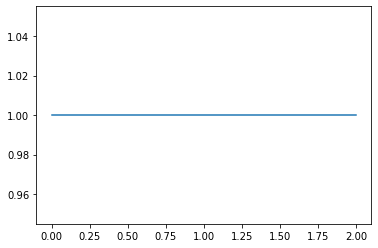

In [27]:
test1 = Testing1(data,model,verbose=1)
test1.run()
test1.plot()

In [5]:
visualization = Visualization("small3/18_12_19_08_51_01")

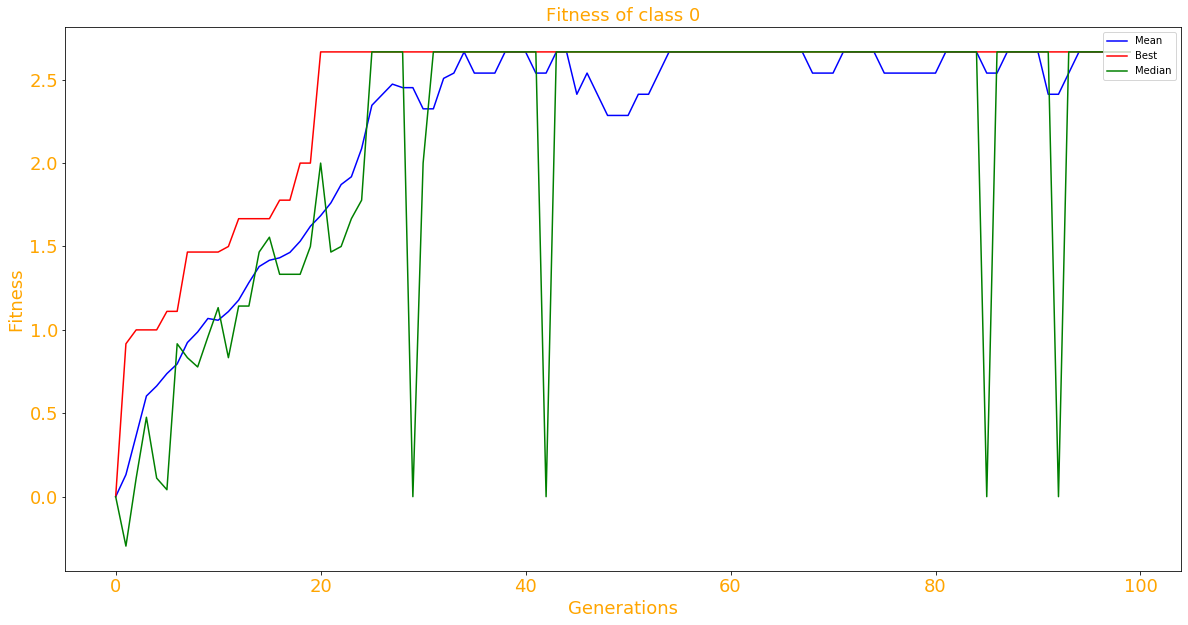

In [6]:
visualization.getFitnessGraph("0")

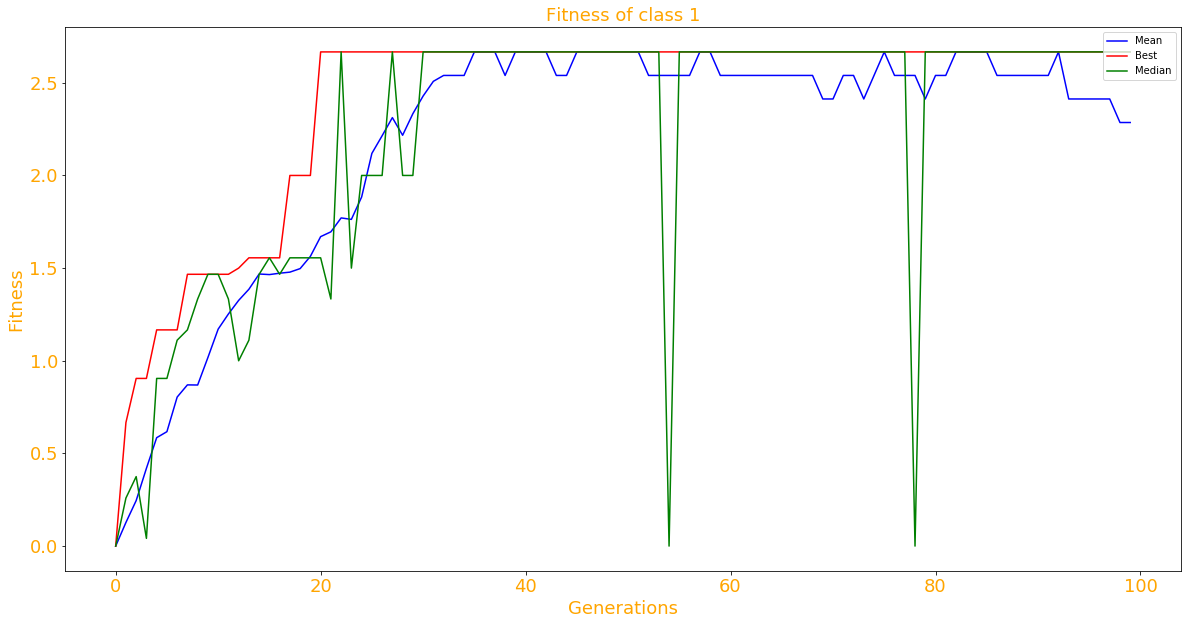

In [7]:
visualization.getFitnessGraph("1")

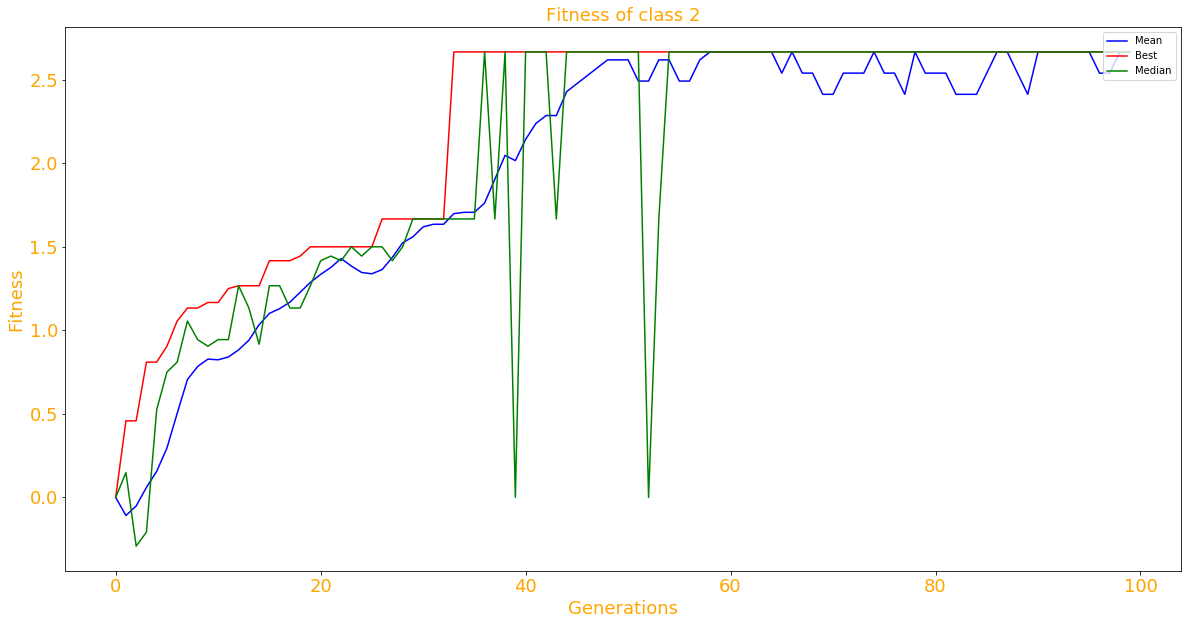

In [8]:
visualization.getFitnessGraph("2")

In [21]:
transformer.lmstr

{0: 'lambda x: x[4] in {2}',
 2: 'lambda x: x[4] in {1}',
 1: 'lambda x: x[4] in {0}'}

In [9]:
exp2.world.toDict()

{'generation': 99,
 'populations': [{'generation': 99,
   'goal': '0',
   'chromosomes': [{'uuid': 'da81928f-3a68-4a03-9a3b-d16c0e00a2db',
     'generation': 20,
     'genes': [{'identifier': '0', 'value': '{-1}'},
      {'identifier': '1', 'value': '{-1}'},
      {'identifier': '2', 'value': 'set()'},
      {'identifier': '3', 'value': '{-1}'},
      {'identifier': '4', 'value': '{2}'},
      {'identifier': '5', 'value': 'set()'},
      {'identifier': '6', 'value': 'set()'},
      {'identifier': '7', 'value': 'set()'},
      {'identifier': '8', 'value': 'set()'}],
     'fitness': '2.6666666666666665',
     'parents': ['fdf33874-fed6-4768-9cef-1cd7e7e1c94e',
      '39de014b-33e6-4404-91b9-99dba7bfac02']},
    {'uuid': 'c4ddbc92-200b-49aa-b974-316c3fe08379',
     'generation': 96,
     'genes': [{'identifier': '0', 'value': 'set()'},
      {'identifier': '1', 'value': '{-1}'},
      {'identifier': '2', 'value': 'set()'},
      {'identifier': '3', 'value': '{-1}'},
      {'identifier': '

In [ ]:
visualization.data[28]["populations"][2]